In [ ]:
import pandas as pd
import numpy as np

def calculate_fdr_log10fdr(data, p_value_col='p.value'):
    """
    Calculate False Discovery Rate (FDR) and log10(FDR) from a pandas DataFrame.

    Args:
        data (pandas.DataFrame): DataFrame containing the data.
        p_value_col (str, optional): Name of the column containing p-values. Default is 'p.value'.

    Returns:
        pandas.DataFrame: Input DataFrame with two new columns 'FDR' and 'log10(FDR)' added.
    """
    # Sort the p-values in ascending order
    data = data.sort_values(by=p_value_col)

    # Rank the sorted p-values
    ranks = np.arange(len(data)) + 1

    # Calculate FDR using the Benjamini-Hochberg procedure
    fdr = data[p_value_col] * len(data) / ranks

    # Calculate log10(FDR)
    log10_fdr = -np.log10(fdr)

    # Add the FDR and log10(FDR) columns to the DataFrame
    data['FDR'] = fdr
    data['-log10(FDR)'] = log10_fdr

    return data

In [ ]:
def filter_and_aggregate_genes(df, pc_gene_list, pvalue_threshold, coefficients, t_condition, annolevel='subclass', celltype='Micro'):
    """
    Filters and aggregates gene data based on specific criteria and statistical thresholds.
    
    Parameters:
    - df (DataFrame): The dataframe containing gene data with columns like 'p.value', 'coef', 'statistic', etc.
    - pc_gene_list (list): List of pre-defined genes of interest.
    - pvalue_threshold (float): Threshold for the p-value; genes with a p-value below this threshold are considered.
    - coefficients (list): A list of coefficients used to filter genes in the dataframe.
    - t_condition (str): Condition for filtering based on the statistic value. It can be '<=0', '>=0', or 'all'.
    - annolevel (str, optional): Annotation level used to further filter genes; defaults to 'subclass'.
    - celltype (str, optional): Specific cell type to further refine the filtering; defaults to 'Micro'.

    Returns:
    DataFrame: A dataframe containing aggregated results for common genes across the different filters, 
    including mean statistics and p-values, sorted by ascending p-value.
    """
    filtered_dfs = []
    for coef in coefficients:
        if t_condition == '<=0':
            filtered_df = df[(df['p.value'] < pvalue_threshold) & (df['coef'] == coef) & (df['statistic'] <= 0) & (df['ID'].isin(pc_gene_list)) & (df['AnnoLevel'] == annolevel) & (df['method'] == 'FE') & (df['assay'] == celltype)]
        elif t_condition == '>=0':
            filtered_df = df[(df['p.value'] < pvalue_threshold) & (df['coef'] == coef) & (df['statistic'] >= 0) & (df['ID'].isin(pc_gene_list) & (df['AnnoLevel'] == annolevel) & (df['method'] == 'FE')) & (df['assay'] == celltype)]
        elif t_condition == 'all':
            filtered_df = df[(df['p.value'] < pvalue_threshold) & (df['coef'] == coef) & (df['ID'].isin(pc_gene_list) & (df['AnnoLevel'] == annolevel) & (df['method'] == 'FE')) & (df['assay'] == celltype)]
        else:
            raise ValueError("Invalid t condition.")
        filtered_dfs.append(set(filtered_df['ID']))

    common_genes = set.union(*filtered_dfs)
    result_df = df[df['ID'].isin(common_genes)]
    result_df = result_df.groupby('ID', as_index=False).agg({'statistic':'mean', 'p.value': 'mean'}).sort_values(by='p.value', ascending=True)
    return result_df


In [ ]:
#find dream genes
META_FNAME = '/sc/arion/projects/psychAD/NPS-AD/freeze2_rc/analysis/results/meta/res_meta.parquet'
res_meta = pd.read_parquet(META_FNAME)

#filter for protein coding genes, remove X and Y sex genes
pc_genes = pd.read_csv('/sc/arion/projects/CommonMind/collin/PsychAD/data/protein_coding_genes/psychad_protein_coding_genes.csv', header=None)
#remove sex-specific genes
pc_genes = pc_genes[pc_genes[3] != 'X']
pc_genes = pc_genes[pc_genes[3] != 'Y']
#filter res_meta for protein coding genes
pc_genes = pc_genes[1].tolist()


#filter for genes with p < 0.05 and m01x
#UPREGULATED_GENES = filter_and_aggregate_genes(res_meta, pc_genes, 0.05, ['m01x'], '>=0', celltype='Micro')
#DOWNREGULATED_GENES = filter_and_aggregate_genes(res_meta, pc_genes, 0.05, ['m01x'], '<=0', celltype='Micro')
SIGNIFICANT_GENES = filter_and_aggregate_genes(res_meta, pc_genes, 0.05, ['m01x'], 'all', celltype='Micro')


In [ ]:
# AD/CTRL, DEMENTIA, BRAAK, CERAD
COEFS = ['m01x', 'm17x', 'm18x', 'm19x']


UPREGULATED_GENES = filter_and_aggregate_genes(res_meta, pc_genes, 0.05, COEFS, '>=0', celltype='Micro')
DOWNREGULATED_GENES = filter_and_aggregate_genes(res_meta, pc_genes, 0.05, COEFS, '<=0', celltype='Micro')
SIGNIFICANT_GENES = filter_and_aggregate_genes(res_meta, pc_genes, 0.05, COEFS, 'all', celltype='Micro')


In [ ]:
#taking the top 50% of genes for each TF
import pandas as pd

# Load your data
SCENIC_GRN = pd.read_csv('/sc/arion/projects/CommonMind/collin/PsychAD/no_var_pilot/UNIVERSAL/consensus_adj/UNIVERSAL_consensus_adj.tsv', sep='\t')

# Set quantile threshold
quantile = 0.8

# Define a function to select regulon genes above the 50th percentile of importance scores
def significant_targets(GRN, TF_list):
    TF_targets_dict = {}
    for TF in TF_list:
        # Filter the data for the current TF
        tf_data = GRN[GRN['TF'] == TF]

        # Sort the data by importance score in descending order
        sorted_tf_data = tf_data.sort_values(by='importance', ascending=False)

        # Calculate the 50th percentile of importance scores
        percentile_50 = sorted_tf_data['importance'].quantile(quantile)

        # Select regulon genes above the 50th percentile
        regulon_genes = sorted_tf_data[sorted_tf_data['importance'] > percentile_50][['target']].target.tolist()

        UPREGULATED_TARGETS = list(set(UPREGULATED_GENES.ID.tolist()) & set(regulon_genes))
        DOWNREGULATED_TARGETS = list(set(DOWNREGULATED_GENES.ID.tolist()) & set(regulon_genes))
        SIGNIFICANT_TARGETS = list(set(SIGNIFICANT_GENES.ID.tolist()) & set(regulon_genes))
        print(TF, 'UPREGULATED_TARGETS:', len(UPREGULATED_TARGETS))
        print(TF, 'DOWNREGULATED_TARGETS:', len(DOWNREGULATED_TARGETS))
        print(TF, 'SIGNIFICANT_TARGETS:', len(SIGNIFICANT_TARGETS))

        TF_targets_dict[TF] = {'UPREGULATED_TARGETS': UPREGULATED_TARGETS, 'DOWNREGULATED_TARGETS': DOWNREGULATED_TARGETS, 'SIGNIFICANT_TARGETS': SIGNIFICANT_TARGETS}
    return TF_targets_dict

TF_list = ['MITF', 'KLF12', 'GLIS3']
# TF_list= ['MITF']
TF_targets_dict = significant_targets(SCENIC_GRN, TF_list)

MITF UPREGULATED_TARGETS: 7
MITF DOWNREGULATED_TARGETS: 3
MITF SIGNIFICANT_TARGETS: 10
KLF12 UPREGULATED_TARGETS: 54
KLF12 DOWNREGULATED_TARGETS: 45
KLF12 SIGNIFICANT_TARGETS: 99
GLIS3 UPREGULATED_TARGETS: 60
GLIS3 DOWNREGULATED_TARGETS: 41
GLIS3 SIGNIFICANT_TARGETS: 101


In [ ]:
#look at signficiant genes for each TF and plot together
def enrich_go(TF):
    print(TF)
    regulon_genes_up = TF_targets_dict[TF]['UPREGULATED_TARGETS']
    regulon_genes_down = TF_targets_dict[TF]['DOWNREGULATED_TARGETS']
    regulon_genes_significant = TF_targets_dict[TF]['SIGNIFICANT_TARGETS']
    

    #Pathways(TF, regulon_genes)
    # enr_GOBP_up = gp.enrichr(gene_list=regulon_genes, gene_sets=['GO_Biological_Process_2023'], organism='Human', cutoff=0.5 ) 
    enr_GOBP_up = gp.enrich(gene_list=regulon_genes_up,
                            gene_sets="/sc/arion/projects/CommonMind/leed62/ref/pathway/GO_Biological_Process_2023.gmt",
                            background=None,
                            verbose=True)
    enr_GOBP_down = gp.enrich(gene_list=regulon_genes_down,
                        gene_sets="/sc/arion/projects/CommonMind/leed62/ref/pathway/GO_Biological_Process_2023.gmt",
                        background=None,
                        verbose=True)
    enr_GOBP_significant = gp.enrich(gene_list=regulon_genes_significant,
                        gene_sets="/sc/arion/projects/CommonMind/leed62/ref/pathway/GO_Biological_Process_2023.gmt",
                        background=None,
                        verbose=True)
    
    
    res_up, res_down = enr_GOBP_up.res2d, enr_GOBP_down.res2d
    res_significant = enr_GOBP_significant.res2d
    res_up['regulon'], res_down['regulon'] = TF+'_up', TF+'_down'
    res_significant['regulon'] = TF+'_significant'
    res = pd.concat([res_up, res_down, res_significant])
    
    # time.sleep(1)
    
    return(res)

merged = pd.concat([enrich_go('MITF'),enrich_go('KLF12'),enrich_go('GLIS3')])
#merged

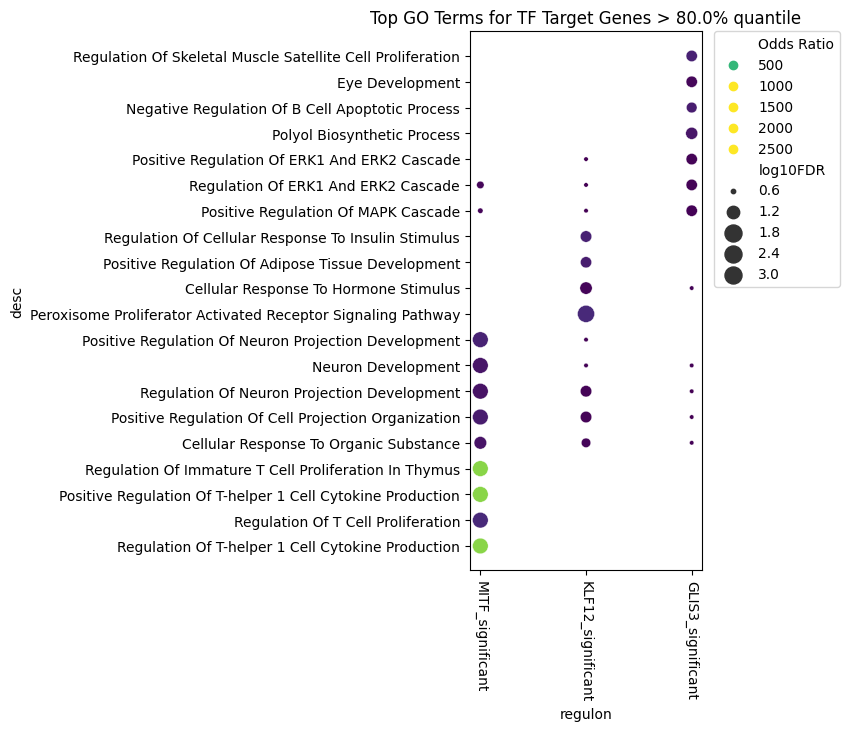

In [ ]:
plot_go_enrichment(merged, TF_list, quantile)